# Test on Coral EdgeTPU

In [28]:
import tensorflow as tf
from pycoral.utils.edgetpu import make_interpreter
import argparse
import time

import numpy as np
from PIL import Image
from pycoral.adapters import classify
from pycoral.adapters import common
from pycoral.utils.dataset import read_label_file

from utils import load_image, plot_sample
import matplotlib.pyplot as plt

In [29]:
interpreter = make_interpreter('bin/srgan_converted_int8_edgetpu.tflite')
interpreter.allocate_tensors() 

# Model must be int8 quantized
if common.input_details(interpreter, 'dtype') != np.uint8:
    raise ValueError('Only support int8 input type.')

[ 1 50 50  3]


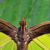

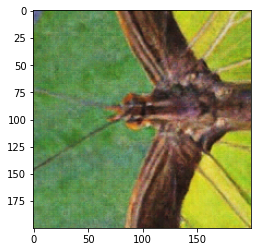

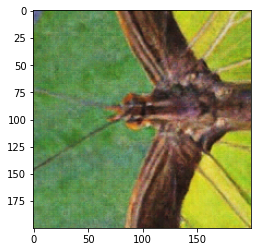

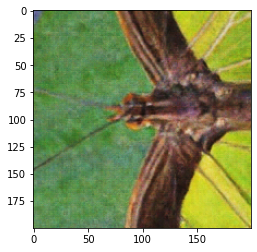

(1, 200, 200, 3)


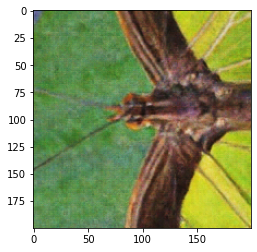

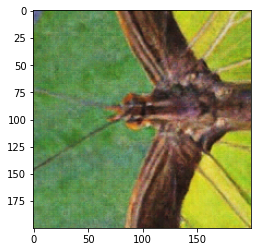

----INFERENCE TIME----
Note: The first inference on Edge TPU is slow because it includes loading the model into Edge TPU memory.
Average Speed: 147.56222246409556 fps


In [30]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on input data.
input_shape = input_details[0]['shape']
print(input_shape)
image = Image.open('./demo/0829x4-crop.png')
#image = image.rotate(180)
image = image.resize(input_shape[1:3])

display(image)

#arr = tf.convert_to_tensor(np.asarray(image, dtype='uint8'))
input_data = np.swapaxes(np.array(image)[None,...],1,2)

input_scale, input_zero_point = input_details[0]['quantization']
test_image_int = input_data / input_scale + input_zero_point
test_image_int=test_image_int.astype(input_details[0]['dtype'])

#plt.imshow(test_image_int[0])

interpreter.set_tensor(input_details[0]['index'], test_image_int)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
plt.imshow(output_data[0])
plt.show()
scale, zero_point = output_details[0]['quantization']
output_data = output_data.astype(np.float32)
plt.imshow(output_data[0].astype(np.uint8))
plt.show()
output_data = (output_data - zero_point) * scale
plt.imshow(output_data[0].astype(np.uint8))
plt.show()
#print(input_scale)
#print(output_data)
#print(input_details[0]["quantization"])

print(output_data.shape)
#plot_sample(input_data[0].astype('uint8'), output_data.astype('uint8')[0])

#plt.imshow(output_data[0].astype('uint8'))
output_data = np.clip(output_data, 0, 255)
plt.imshow(output_data[0].astype(np.uint8))
plt.show()
output_data = np.round(output_data)
plt.imshow(output_data[0].astype(np.uint8))
plt.show()
#plt.imshow(output_data[0].astype('uint8'))

# Run inference
print('----INFERENCE TIME----')
print('Note: The first inference on Edge TPU is slow because it includes',
    'loading the model into Edge TPU memory.')
lat = []
for _ in range(10):
    start = time.perf_counter()
    interpreter.invoke()
    inference_time = time.perf_counter() - start
    lat.append(inference_time)
    classes = classify.get_classes(interpreter, 1, 0.5)
    # print('%.1fms' % (inference_time * 1000))
_ = lat.pop()
print(f'Average Speed: {1/np.mean(np.array(lat))} fps')

(1, 200, 200, 3)


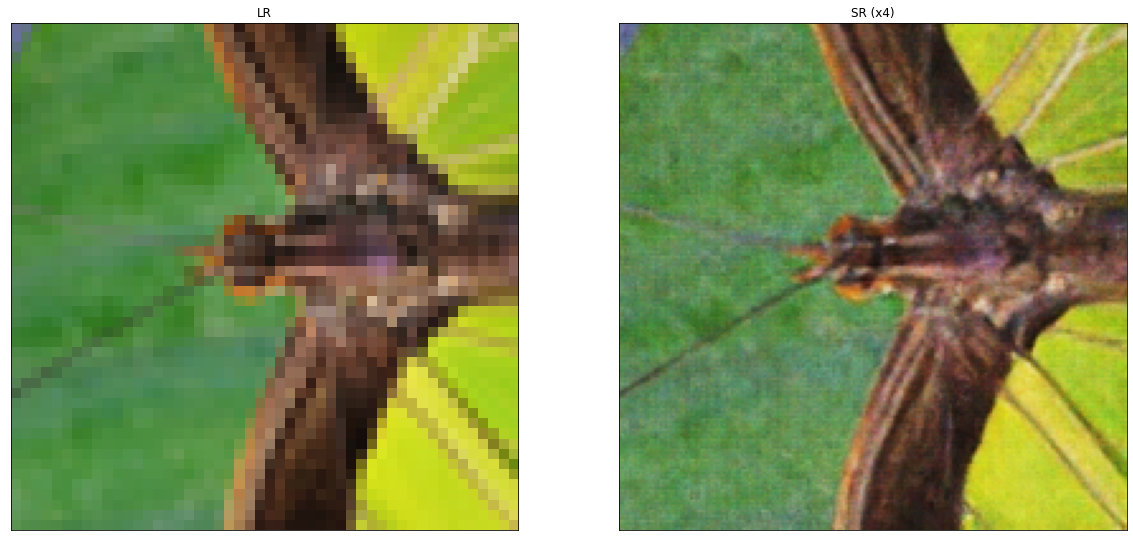

In [31]:
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

print(output_data.shape)
plot_sample(input_data[0].astype('uint8'), output_data.astype('uint8')[0])